In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#INITIALIZING DATA

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# path = '/content/drive/MyDrive/fall2025/csci5526/CSCI 5526 Project/clean_dataset.csv' # Kenna
path = "/content/drive/MyDrive/csci5526project/clean_dataset.csv"
df = pd.read_csv(path)

print("Original shape:", df.shape)

#converting the time columns to real datetimes (needed for ICU readmission label)
for col in ["ADMITTIME", "DISCHTIME", "INTIME", "OUTTIME"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")






#for different models:

#a) 30-day readmission-- READMIT_30D already computed in prep.ipynb

#b) Mortality
#use HOSPITAL_EXPIRE_FLAG (0 = survived, 1 = died in hospital)
if "HOSPITAL_EXPIRE_FLAG" in df.columns:
    df["HOSPITAL_EXPIRE_FLAG"] = df["HOSPITAL_EXPIRE_FLAG"].fillna(0).astype(int)

#c) ICU readmission within 30 days
#next ICU admission for the same SUBJECT_ID starting within 30 days (720 hours) after current ICU OUTTIME.
if {"SUBJECT_ID", "INTIME", "OUTTIME"}.issubset(df.columns):
    df = df.sort_values(["SUBJECT_ID", "INTIME"])
    df["NEXT_ICU_INTIME"] = df.groupby("SUBJECT_ID")["INTIME"].shift(-1)

    df["HOURS_TO_NEXT_ICU"] = (
        (df["NEXT_ICU_INTIME"] - df["OUTTIME"]).dt.total_seconds() / 3600
    )

    df["ICU_READMIT_30D"] = (df["HOURS_TO_NEXT_ICU"] <= 720).astype(float)
    df["ICU_READMIT_30D"] = df["ICU_READMIT_30D"].fillna(0).astype(int)
else:
    print("Warning: cannot create ICU_READMIT_30D (missing SUBJECT_ID/INTIME/OUTTIME).")






#dropping columns
cols_to_drop = [
    # unneeded identifiers
    "ROW_ID_x", "ROW_ID_y", "ROW_ID",
    "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID",

    # unused time columns (we already used them for labels)
    "ADMITTIME", "DISCHTIME", "DEATHTIME",
    "EDREGTIME", "EDOUTTIME", "INTIME", "OUTTIME",
    "DOB", "DOD", "DOD_HOSP", "DOD_SSN",

    # label construction helpers (would leak information)
    "NEXT_ADMITTIME", "HOURS_TO_NEXT",
    "NEXT_ICU_INTIME", "HOURS_TO_NEXT_ICU",

    # extra mortality-related flag that can leak label info
    "EXPIRE_FLAG",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("After dropping ID / time / helper cols:", df.shape)

#dropping columns with >80% NaN
nan_threshold = 0.8
df = df.dropna(axis=1, thresh=len(df) * (1 - nan_threshold))
print("After dropping mostly-NaN columns:", df.shape)

#make sure our three targets still exist
label_cols = ["READMIT_30D", "HOSPITAL_EXPIRE_FLAG", "ICU_READMIT_30D"]
label_cols = [c for c in label_cols if c in df.columns]
print("Available targets:", label_cols)


#smaller controlled set of categorical variables to use
allowed_categoricals = [
    "GENDER",
    "ADMISSION_TYPE",
    "INSURANCE",
    "ETHNICITY",
]

comorb_cols = [
    "Diabetes",
    "CHF",
    "CAD",
    "Hypertension",
    "Renal_Failure",
    "COPD",
    "Liver_Disease",
    "Respiratory_Failure",
    "AMI",
    "Sepsis",
]


Original shape: (62722, 101)
After dropping ID / time / helper cols: (62722, 82)
After dropping mostly-NaN columns: (62722, 82)
Available targets: ['READMIT_30D', 'HOSPITAL_EXPIRE_FLAG', 'ICU_READMIT_30D']


In [4]:
df.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,...,mean_51265,mean_51300,min_50912,min_50971,min_50983,min_51006,min_51222,min_51265,min_51300,ICU_READMIT_30D
0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NEWBORN,0,...,153.50,6.25,0.9,4.0,138.0,18.0,0.0,5.0,6.25,0
1,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,HYPOTENSION,0,...,255.25,6.25,2.4,3.9,138.0,41.0,7.8,190.0,6.25,0
2,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,...,201.00,6.25,0.5,3.3,141.0,10.0,10.6,201.0,6.25,0
3,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NEWBORN,0,...,309.00,6.25,0.9,4.0,138.0,18.0,14.9,309.0,6.25,0
4,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHRONIC RENAL FAILURE/SDA,0,...,322.50,6.25,10.0,4.8,134.0,62.0,9.2,315.0,6.25,0


#FEATURE IMPORTANCE

In [5]:
# function to look at feature importance for a logistic regression model
# code from GeeksforGeeks
def feature_importance(model, X):
  '''compute and display feature importance for logistic regression model'''
  # Coefficients and Odds Ratios
  coefficients = model.coef_[0]
  odds_ratios = np.exp(coefficients)

  # Display feature importance using coefficients and odds ratios
  feature_importance = pd.DataFrame({
      'Feature': X.columns,
      'Coefficient': coefficients,
      'Odds Ratio': odds_ratios
  })
  print("\nFeature Importance (Coefficient and Odds Ratio):")
  print(feature_importance.sort_values(by='Coefficient', ascending=False))

# Vital item IDs (MIMIC-III standard)
VITALS = {
    "HR": [220045],
    "SysBP": [220179, 51],
    "DiasBP": [220180, 8368],
    "MeanBP": [220181],
    "RR": [220210],
    "SpO2": [220277],
    "TempC": [223761, 678],
}

# Lab item IDs
LABS = {
    "WBC": [51300],
    "HGB": [51222],
    "Platelets": [51265],
    "Sodium": [50983],
    "Potassium": [50971],
    "Creatinine": [50912],
    "BUN": [51006],
}

def convert_ids_to_feature_names(df, VITALS, LABS):
  '''convert column IDs back to feature names
  used for feature importance'''
  id_dict = VITALS | LABS
  mapper = {}
  cols = df.columns
  for col in cols:
    new_col = col
    for key,val in id_dict.items():
    # replace the ID value with the key in each column
      if str(val[0]) in col:
        new_col = col.replace(str(val[0]),key)
        break
    mapper[col] = new_col
    #[col.replace(str(val),key) for col in cols if col.endswith(str(val))]
  df_new  = df.rename(columns=mapper)
  return mapper, df_new

#INITIAL LOGREG FUNCTION


LOGISTIC REGRESSION FOR TARGET: READMIT_30D
Feature matrix shape: (62722, 118)
Accuracy: 0.6310083698684735
AUROC: 0.6730073255072395
Confusion Matrix:
 [[7018 4100]
 [ 529  898]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75     11118
           1       0.18      0.63      0.28      1427

    accuracy                           0.63     12545
   macro avg       0.55      0.63      0.52     12545
weighted avg       0.84      0.63      0.70     12545



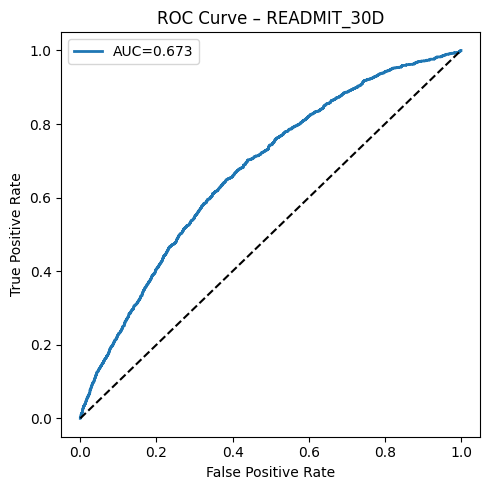

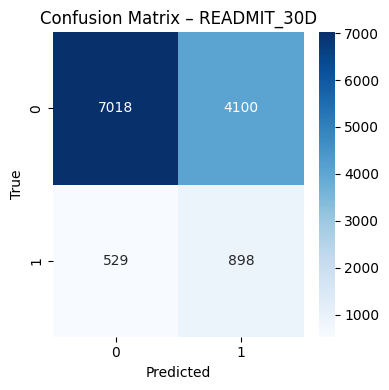

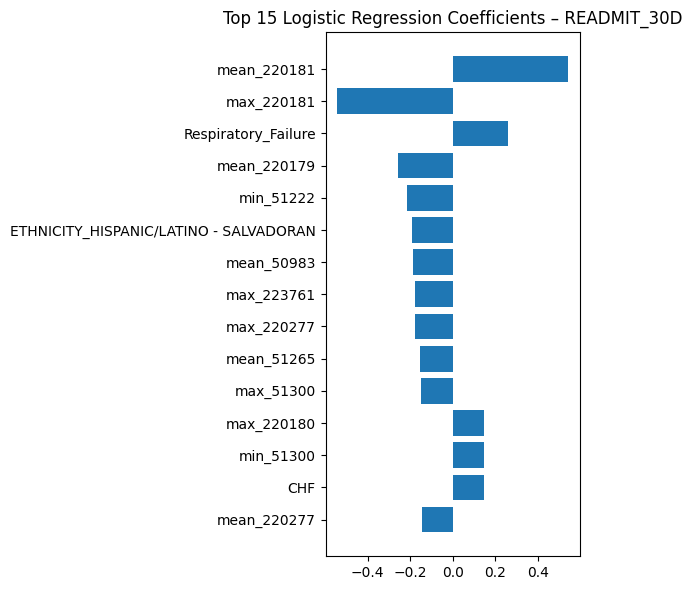


LOGISTIC REGRESSION FOR TARGET: HOSPITAL_EXPIRE_FLAG
Feature matrix shape: (62722, 118)
Accuracy: 0.7445197289756875
AUROC: 0.8251410738169542
Confusion Matrix:
 [[8361 2854]
 [ 351  979]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84     11215
           1       0.26      0.74      0.38      1330

    accuracy                           0.74     12545
   macro avg       0.61      0.74      0.61     12545
weighted avg       0.89      0.74      0.79     12545



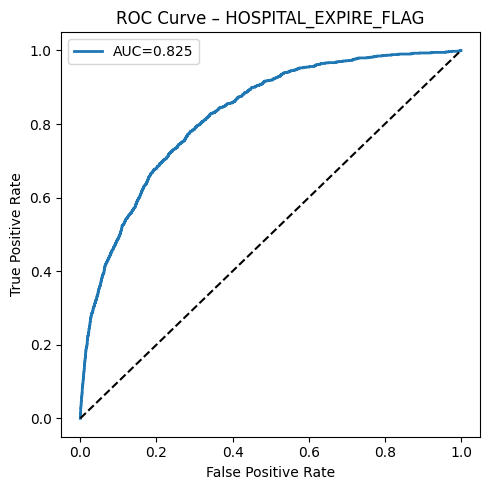

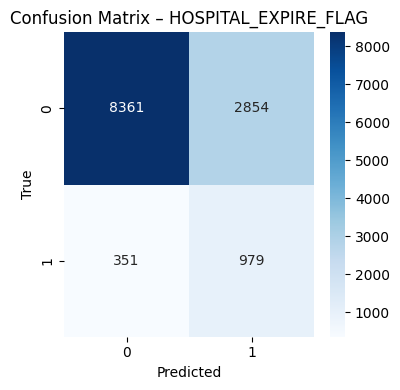

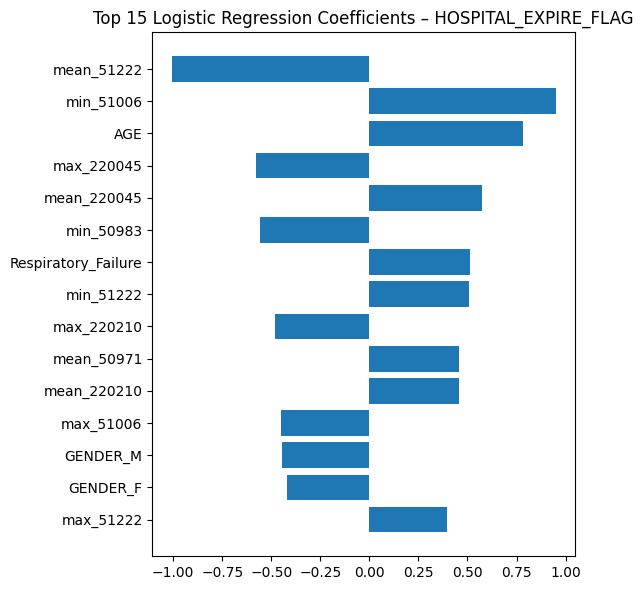


LOGISTIC REGRESSION FOR TARGET: ICU_READMIT_30D
Feature matrix shape: (62722, 118)
Accuracy: 0.6433638899960143
AUROC: 0.6876595810924221
Confusion Matrix:
 [[7266 4002]
 [ 472  805]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76     11268
           1       0.17      0.63      0.26      1277

    accuracy                           0.64     12545
   macro avg       0.55      0.64      0.51     12545
weighted avg       0.86      0.64      0.71     12545



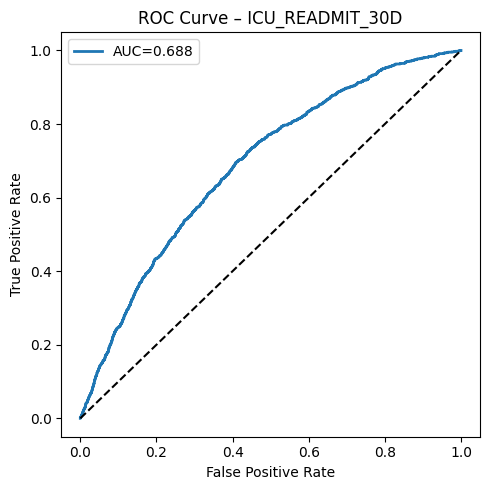

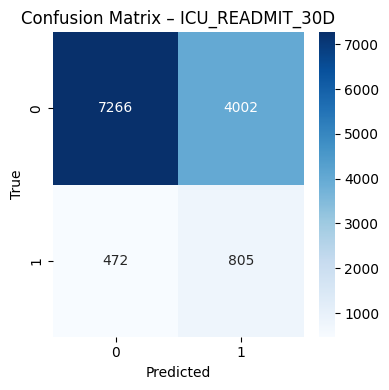

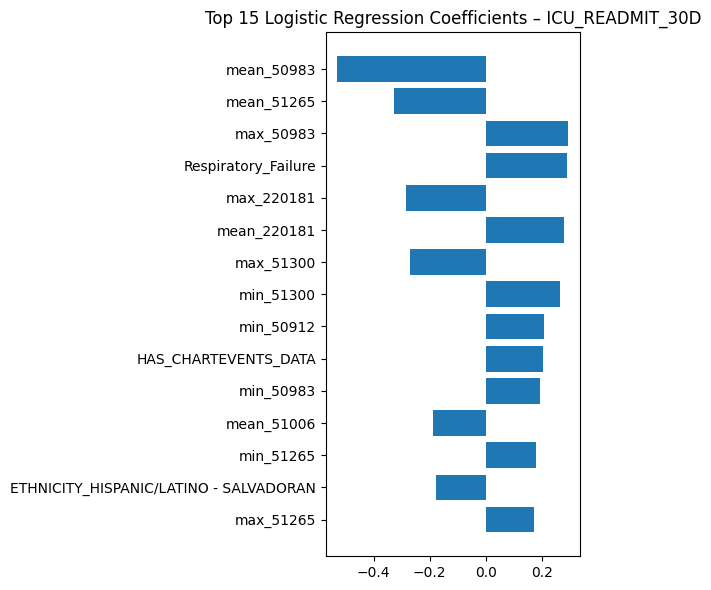

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# ================================
# PLOT ROC
# ================================
def plot_roc_curve(y_test, y_prob, target_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC={auc_val:.3f}")
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {target_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ================================
# CONFUSION MATRIX HEATMAP
# ================================
def plot_confusion(cm, target_name):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {target_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ================================
# TOP LOGISTIC COEFFICIENTS
# ================================
def plot_top_coefficients(model, feature_names, target_name, top_n=15):
    coefs = model.coef_.ravel()
    idx = np.argsort(np.abs(coefs))[-top_n:]  # top n by magnitude

    plt.figure(figsize=(6,6))
    plt.barh(feature_names[idx], coefs[idx])
    plt.title(f"Top {top_n} Logistic Regression Coefficients – {target_name}")
    plt.tight_layout()
    plt.show()

#function to train and run logistic regression model for any target
def run_logistic_for_target(df, target_col):
    print("\n" + "="*60)
    print(f"LOGISTIC REGRESSION FOR TARGET: {target_col}")
    print("="*60)

    #don't allow any of the label (target) columns to be features
    labels_present = [c for c in label_cols if c in df.columns]
    feature_df = df.drop(columns=labels_present)

    y = df[target_col]
    X = feature_df.copy()

    #keep only numeric features + the small set of allowed categoricals
    categorical_cols = [c for c in allowed_categoricals if c in X.columns]
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    X = X[numeric_cols + categorical_cols].copy()

    #one-hot encode only the small categorical set
    X = pd.get_dummies(X, columns=categorical_cols)

    print("Feature matrix shape:", X.shape)

    #train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    #scaling numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # fitting the actual model
    logreg = LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced"
    )
    logreg.fit(X_train_scaled, y_train)

    # evaluation metrics
    y_pred = logreg.predict(X_test_scaled)
    y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    try:
        auc = roc_auc_score(y_test, y_prob)
        print("AUROC:", auc)
    except ValueError:
        print("AUROC: could not be computed (only one class in y_test?)")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))



    # ROC curve
    plot_roc_curve(y_test, y_prob, target_col)

    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, target_col)

    # Top coefficient plot
    feature_names = np.array(X.columns)
    plot_top_coefficients(logreg, feature_names, target_col)

    return logreg, X











#running the models:

# 30 day readmission
if "READMIT_30D" in label_cols:
    _,_= run_logistic_for_target(df, "READMIT_30D")

# mortality
if "HOSPITAL_EXPIRE_FLAG" in label_cols:
    _,_= run_logistic_for_target(df, "HOSPITAL_EXPIRE_FLAG")

# ICU readmission
if "ICU_READMIT_30D" in label_cols:
    logreg,X = run_logistic_for_target(df, "ICU_READMIT_30D")

In [7]:
# feature importance
_, df_new = convert_ids_to_feature_names(X.copy(), VITALS, LABS)
feature_importance(logreg, df_new)


Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
47           max_Sodium     0.295788    1.344186
12  Respiratory_Failure     0.288955    1.335031
31          mean_MeanBP     0.278645    1.321338
65              min_WBC     0.267405    1.306570
59       min_Creatinine     0.209477    1.233033
..                  ...          ...         ...
55             mean_BUN    -0.189083    0.827718
51              max_WBC    -0.270996    0.762619
21           max_MeanBP    -0.284834    0.752139
57       mean_Platelets    -0.327437    0.720769
54          mean_Sodium    -0.530620    0.588240

[118 rows x 3 columns]


#REGULARIZATION

In [12]:

# =========================================
# 4. SIMPLE FEATURE MATRIX BUILDER (BASELINE = "all")
# =========================================

def build_features_all(df, target_col):
    # don't allow any of the label columns to be features
    labels_present = [c for c in label_cols if c in df.columns]
    feature_df = df.drop(columns=labels_present)

    y = df[target_col]
    X = feature_df.copy()

    categorical_cols = [c for c in allowed_categoricals if c in X.columns]
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    X = X[numeric_cols + categorical_cols].copy()
    X = pd.get_dummies(X, columns=categorical_cols)

    return X, y




# =========================================
# REGULARIZATION EXPERIMENT (vary C)
# =========================================

target_col = "HOSPITAL_EXPIRE_FLAG"   # you can change to "READMIT_30D" or "ICU_READMIT_30D"

X, y = build_features_all(df, target_col)
print("Feature matrix shape:", X.shape)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# scaling numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C_values = [0.001, 0.01, 0.1, 1.0, 10.0]

for C in C_values:
    print("\n" + "-"*50)
    print(f"Logistic Regression with C = {C}")
    print("-"*50)

    logreg = LogisticRegression(
        C=C,
        max_iter=500,
        solver="lbfgs",
        class_weight="balanced"
    )
    logreg.fit(X_train_scaled, y_train)

    y_pred = logreg.predict(X_test_scaled)
    y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Accuracy:", acc)
    print("AUROC:", auc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

Feature matrix shape: (62722, 118)

--------------------------------------------------
Logistic Regression with C = 0.001
--------------------------------------------------
Accuracy: 0.7426863292148266
AUROC: 0.8231469668375129
Confusion Matrix:
 [[8343 2872]
 [ 356  974]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.74      0.84     11215
           1       0.25      0.73      0.38      1330

    accuracy                           0.74     12545
   macro avg       0.61      0.74      0.61     12545
weighted avg       0.88      0.74      0.79     12545


--------------------------------------------------
Logistic Regression with C = 0.01
--------------------------------------------------
Accuracy: 0.7445994420087685
AUROC: 0.8247636255149688
Confusion Matrix:
 [[8359 2856]
 [ 348  982]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84     11215
  

#USING EPOCHS

In [9]:
# =========================================
# EPOCH / ITERATION EXPERIMENT (vary max_iter)
# =========================================

target_col = "READMIT_30D"   # change if you want

X, y = build_features_all(df, target_col)
print("Feature matrix shape:", X.shape)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# scaling numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

max_iter_values = [100, 200, 500, 1000]

for max_iter in max_iter_values:
    print("\n" + "-"*50)
    print(f"Logistic Regression with max_iter = {max_iter}")
    print("-"*50)

    logreg = LogisticRegression(
        C=1.0,                 # fixed regularization
        max_iter=max_iter,
        solver="lbfgs",
        class_weight="balanced"
    )
    logreg.fit(X_train_scaled, y_train)

    y_pred = logreg.predict(X_test_scaled)
    y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Accuracy:", acc)
    print("AUROC:", auc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

Feature matrix shape: (62722, 118)

--------------------------------------------------
Logistic Regression with max_iter = 100
--------------------------------------------------
Accuracy: 0.6310083698684735
AUROC: 0.6730073255072395
Confusion Matrix:
 [[7018 4100]
 [ 529  898]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75     11118
           1       0.18      0.63      0.28      1427

    accuracy                           0.63     12545
   macro avg       0.55      0.63      0.52     12545
weighted avg       0.84      0.63      0.70     12545


--------------------------------------------------
Logistic Regression with max_iter = 200
--------------------------------------------------
Accuracy: 0.6310083698684735
AUROC: 0.6730073255072395
Confusion Matrix:
 [[7018 4100]
 [ 529  898]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75  

#FEATURE MANIPULATION

In [10]:
# =========================================
# FEATURE SUBSET EXPERIMENT
# =========================================

def build_features_demo_comorb(df, target_col):
    # age + comorbidities + small categoricals
    labels_present = [c for c in label_cols if c in df.columns]
    feature_df = df.drop(columns=labels_present)

    y = df[target_col]
    X = feature_df.copy()

    categorical_cols = [c for c in allowed_categoricals if c in X.columns]

    numeric_cols = []
    if "AGE" in X.columns:
        numeric_cols.append("AGE")
    for col in comorb_cols:
        if col in X.columns:
            numeric_cols.append(col)

    X = X[numeric_cols + categorical_cols].copy()
    X = pd.get_dummies(X, columns=categorical_cols)

    return X, y


def build_features_vitals_labs(df, target_col):
    # vitals/labs stats (max_/min_/mean_) + AGE + small categoricals
    labels_present = [c for c in label_cols if c in df.columns]
    feature_df = df.drop(columns=labels_present)

    y = df[target_col]
    X = feature_df.copy()

    categorical_cols = [c for c in allowed_categoricals if c in X.columns]
    numeric_cols_all = X.select_dtypes(include=[np.number]).columns.tolist()

    numeric_cols = []
    for col in numeric_cols_all:
        if col.startswith(("max_", "min_", "mean_")):
            numeric_cols.append(col)
    if "AGE" in X.columns:
        numeric_cols.append("AGE")

    X = X[numeric_cols + categorical_cols].copy()
    X = pd.get_dummies(X, columns=categorical_cols)

    return X, y


target_col = "READMIT_30D"   # swap to other targets if you want
feature_builders = {
    "all": build_features_all,
    "demo_comorb": build_features_demo_comorb,
    "vitals_labs": build_features_vitals_labs,
}

for mode, builder in feature_builders.items():
    print("\n" + "="*60)
    print(f"FEATURE MODE: {mode}")
    print("="*60)

    X, y = builder(df, target_col)
    print("Feature matrix shape:", X.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    logreg = LogisticRegression(
        C=1.0,
        max_iter=500,
        solver="lbfgs",
        class_weight="balanced"
    )
    logreg.fit(X_train_scaled, y_train)

    y_pred = logreg.predict(X_test_scaled)
    y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print("Accuracy:", acc)
    print("AUROC:", auc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


FEATURE MODE: all
Feature matrix shape: (62722, 118)
Accuracy: 0.6310083698684735
AUROC: 0.6730073255072395
Confusion Matrix:
 [[7018 4100]
 [ 529  898]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75     11118
           1       0.18      0.63      0.28      1427

    accuracy                           0.63     12545
   macro avg       0.55      0.63      0.52     12545
weighted avg       0.84      0.63      0.70     12545


FEATURE MODE: demo_comorb
Feature matrix shape: (62722, 63)
Accuracy: 0.629653248306098
AUROC: 0.6655417964618069
Confusion Matrix:
 [[7010 4108]
 [ 538  889]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75     11118
           1       0.18      0.62      0.28      1427

    accuracy                           0.63     12545
   macro avg       0.55      0.63      0.51     12545
weighted avg       0.84      0.63  

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


# =========================================
# BEST-RESULTS SWEEP (C values + feature subsets)
# =========================================

def eval_one_setting(df, target_col, builder_fn, C=1.0, max_iter=500):
    X, y = builder_fn(df, target_col)

    # train/test split (same as your runs)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        C=C,
        max_iter=max_iter,
        solver="lbfgs",
        class_weight="balanced"
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    return acc, auc, X.shape[1]


def find_best_for_target(df, target_col):
    # feature builders you already defined in your notebook
    builders = {
        "all": build_features_all,
        "demo_comorb": build_features_demo_comorb,
        "vitals_labs": build_features_vitals_labs,
    }

    C_values = [0.001, 0.01, 0.1, 1.0, 10.0]

    rows = []

    # baseline = full features, C=1.0
    base_acc, base_auc, base_k = eval_one_setting(df, target_col, builders["all"], C=1.0)
    rows.append({
        "Target": target_col,
        "Setting": "Baseline (all features, C=1.0)",
        "Features": base_k,
        "C": 1.0,
        "Accuracy": base_acc,
        "AUROC": base_auc
    })

    # best-C using all features
    bestC = None
    bestC_auc = -1
    bestC_acc = None
    bestC_k = None
    for C in C_values:
        acc, auc, k = eval_one_setting(df, target_col, builders["all"], C=C)
        if auc > bestC_auc:
            bestC_auc = auc
            bestC = C
            bestC_acc = acc
            bestC_k = k

    rows.append({
        "Target": target_col,
        "Setting": "Best regularization (all features)",
        "Features": bestC_k,
        "C": bestC,
        "Accuracy": bestC_acc,
        "AUROC": bestC_auc
    })

    # best feature subset using fixed C = bestC (fair comparison)
    bestFS = None
    bestFS_auc = -1
    bestFS_acc = None
    bestFS_k = None
    for name, fn in builders.items():
        acc, auc, k = eval_one_setting(df, target_col, fn, C=bestC)
        if auc > bestFS_auc:
            bestFS_auc = auc
            bestFS = name
            bestFS_acc = acc
            bestFS_k = k

    rows.append({
        "Target": target_col,
        "Setting": f"Best feature subset (C={bestC})",
        "Features": bestFS_k,
        "C": bestC,
        "Accuracy": bestFS_acc,
        "AUROC": bestFS_auc,
        "FeatureMode": bestFS
    })

    return pd.DataFrame(rows)


# =========================================
# RUN FOR ALL 3 OUTCOMES AND BUILD FINAL TABLE
# =========================================

targets = ["READMIT_30D", "HOSPITAL_EXPIRE_FLAG", "ICU_READMIT_30D"]
targets = [t for t in targets if t in df.columns]

summary_tables = []
for t in targets:
    summary_tables.append(find_best_for_target(df, t))

final_summary = pd.concat(summary_tables, ignore_index=True)
final_summary

,Target,Setting,Features,C,Accuracy,AUROC,FeatureMode
0,READMIT_30D,"Baseline (all features, C=1.0)",118,1.000,0.631008,0.673007,NaN
1,READMIT_30D,Best regularization (all features),118,0.001,0.630530,0.673456,NaN
2,READMIT_30D,Best feature subset (C=0.001),118,0.001,0.630530,0.673456,all
3,HOSPITAL_EXPIRE_FLAG,"Baseline (all features, C=1.0)",118,1.000,0.744520,0.825141,NaN
4,HOSPITAL_EXPIRE_FLAG,Best regularization (all features),118,10.000,0.745636,0.826259,NaN
5,HOSPITAL_EXPIRE_FLAG,Best feature subset (C=10.0),118,10.000,0.745636,0.826259,all
6,ICU_READMIT_30D,"Baseline (all features, C=1.0)",118,1.000,0.643364,0.687660,NaN
7,ICU_READMIT_30D,Best regularization (all features),118,0.001,0.640733,0.688055,NaN
8,ICU_READMIT_30D,Best feature subset (C=0.001),118,0.001,0.640733,0.688055,all
